In [2]:
from dataset import dataset, Encoder, Collate
from model import CRNNModel
import transform

import torch
from torch.utils.data import DataLoader
import albumentations as A
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_transforms = A.Compose([
    transform.Deslant(always_apply=True, p=1.0),
    transform.Binarize(p=0.3),
    A.augmentations.geometric.transforms.Affine(
        scale=0.8, shear=(-3, 3), cval=(195, 255), p=0.8,
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),
    A.augmentations.geometric.Resize(
        height=128, width=1024, p=1.0, always_apply=True),
    A.augmentations.transforms.Blur(blur_limit=(3, 4), p=0.4),
    A.augmentations.transforms.GaussNoise(var_limit=(
        10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.3),
    transform.Binarize(p=0.3),
    transform.Rotate(always_apply=True, p=1.0),
    transform.ToTensor(always_apply=True, p=1.0)
])

In [4]:
trainset, validset, testset = dataset('IAM', '/mnt/d/Machine-Learning/Datasets/iamdataset/uncompressed',
                                    csv_file_path='IAM_df.csv', default_partition=False, partition=(0.7, 0.1, 0.2), shuffle=False, seed=42,
                                   train_transform=train_transforms)

In [5]:
trainset.data.head()

,Image,Segmentation,Transcription,Threshold
0,a01-000u-00,ok,A MOVE to stop Mr. Gaitskell from,154
1,a01-000u-01,ok,nominating any more Labour life Peers,156
2,a01-000u-02,ok,is to be made at a meeting of Labour,157
3,a01-000u-03,err,M Ps tomorrow. Mr. Michael Foot has,156
4,a01-000u-04,ok,put down a resolution on the subject,157


In [6]:
print("Number of samples:", len(trainset.data) + len(testset.data) + len(validset.data))
print("Character set:", trainset.charset)

Number of samples: 13353
Character set:  !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [7]:
encoder = Encoder(trainset.charset)
collater = Collate(encoder)

train_loader = DataLoader(trainset,
    batch_size=32,
    shuffle=True,
    collate_fn=collater,
    num_workers=0
)
val_loader = DataLoader(validset,
    batch_size=16,
    shuffle=False,
    collate_fn=collater, 
    num_workers=0
)
test_loader = DataLoader(testset,
    batch_size=16,
    shuffle=False, 
    collate_fn=collater,
    num_workers=0
)

In [8]:
train_batch = next(iter(train_loader))
images, targets, target_lengths, targets_original = train_batch

In [9]:
images.shape

torch.Size([32, 1, 1024, 128])

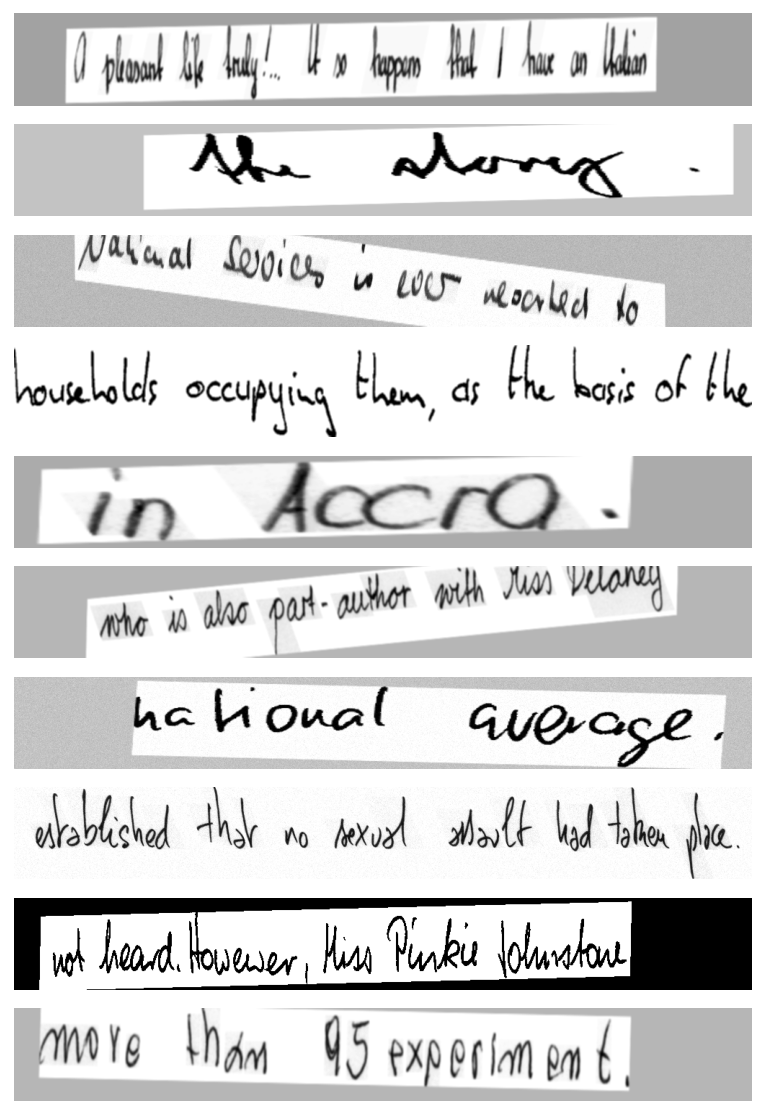

In [10]:
f, axes = plt.subplots(nrows=10, ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images[:10]):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    axes[i].imshow(image, cmap='gray')

In [21]:
test_batch = next(iter(test_loader))
images, targets, target_lengths, targets_original = test_batch

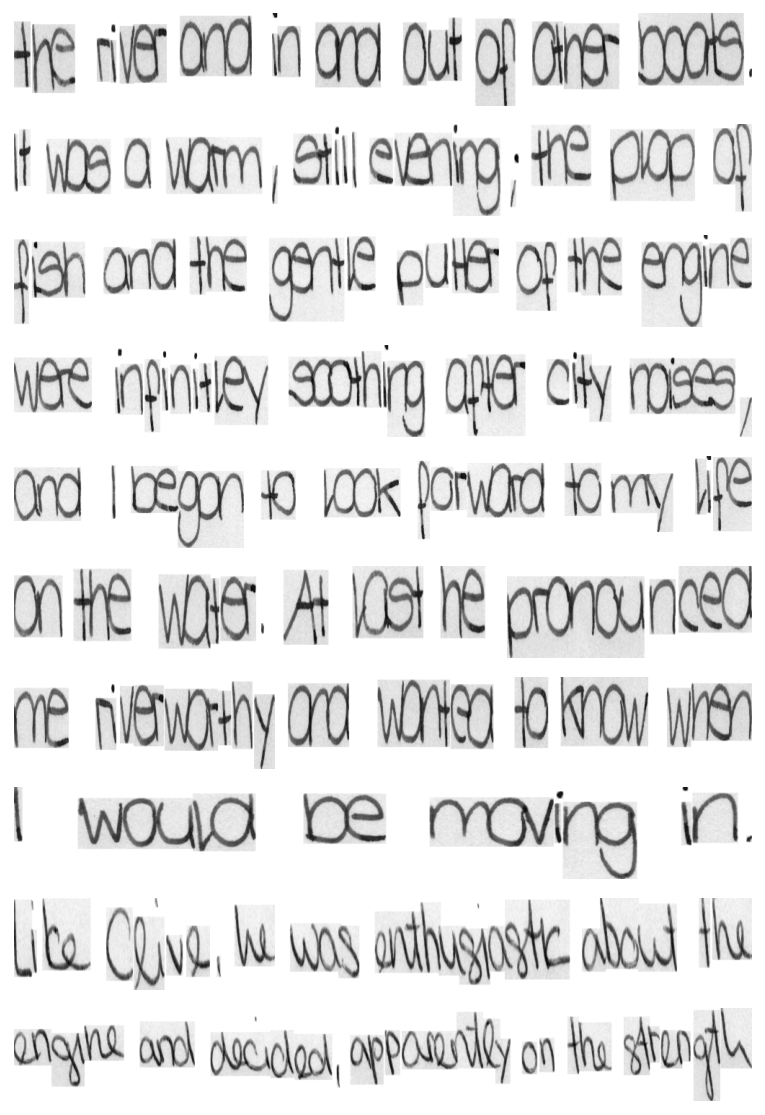

In [22]:
f, axes = plt.subplots(nrows=10, ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images[:10]):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    axes[i].imshow(image, cmap='gray')

In [28]:
validset.data.head()

,Image,Segmentation,Transcription,Threshold
0,j04-046-08,ok,strength of the carbonate solution was,175
1,j04-046-09,ok,chosen after experiments with lead tracer,175
2,j04-046-10,ok,alone which indicated that less lead was,173
3,j04-053-00,ok,A small manual coffee grinder is useful as the...,188
4,j04-053-01,ok,cannot be ground with a mortar and pestle. The,186


## Bentham

In [6]:
trainset, validset, testset = dataset('Bentham', '/mnt/d/Machine-Learning/Datasets/bentham/uncompressed',
                                    csv_file_path=None, default_partition=False, partition=(0.7, 0.1, 0.2), shuffle=False, seed=42,
                                   train_transform=train_transforms)

Loading dataset: 100%|██████████| 11473/11473 [07:25<00:00, 25.73it/s]


In [7]:
trainset.data.head()

,Image,Transcription,Length
0,002_080_001_03_01,"6 . The evidence of the engagement , consigned...",60
1,002_080_001_03_02,"instrument , instead of a fixed Book . _ Tak...",60
2,002_080_001_03_03,"quer Bills , _ Differs from Stock Annuities ...",60
3,002_080_001_03_04,"Irish Debentures , and the now disused Navy Vi...",50
4,002_080_001_03_05,alling Transport and Ordnance Bills or Debentu...,55


In [8]:
print(len(trainset), len(validset), len(testset))
print(len(trainset) + len(validset) + len(testset))

6693 955 1911
9559


In [19]:
trainset.charset

' !"#&\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|£§àâèéê⊥'

In [20]:
encoder = Encoder(trainset.charset)
collater = Collate(encoder)

train_loader = DataLoader(trainset,
    batch_size=32,
    shuffle=True,
    collate_fn=collater,
    num_workers=0
)
val_loader = DataLoader(validset,
    batch_size=16,
    shuffle=False,
    collate_fn=collater, 
    num_workers=0
)
test_loader = DataLoader(testset,
    batch_size=16,
    shuffle=False, 
    collate_fn=collater,
    num_workers=0
)

In [24]:
train_batch = next(iter(train_loader))
images, targets, target_lengths, targets_original = train_batch

In [25]:
images.shape

torch.Size([32, 1, 1024, 128])

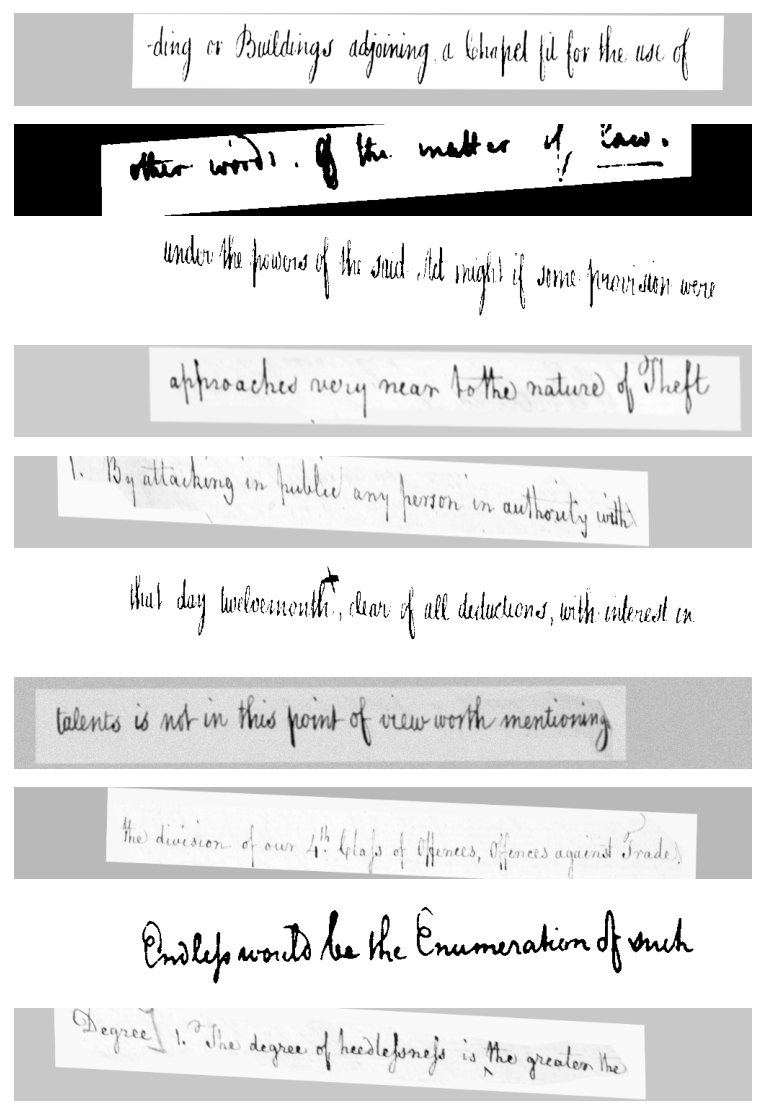

In [26]:
f, axes = plt.subplots(nrows=10, ncols=1, figsize=(20, 10))

for ax in axes:
    ax.axis('off')

for i, image in enumerate(images[:10]):
    image = torch.squeeze(image, dim=0).numpy()
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    axes[i].imshow(image, cmap='gray')